### Problem 2

#### (a)

$$
\mathbb{E}_{y|x} [L(y, f(x)] = \sum_{k=1}^K \exp (\sum_{k'\neq k}\frac{f_{k'}(x)}{K(K-1)}-\frac{f_k(x)}{K})P(c = k| x)
$$
$$
\mathcal{L} = \sum_{k=1}^K \exp (-\frac{f_k(x)}{K-1})P(c = k| x)- \lambda \sum_{k=1}^K f_k(x)
$$

Taking derivative gives the following result:
$$
P\left(c=k \mid x\right)=\left\{\prod_{k^{\prime}=1}^{K} P\left(c=k' \mid x\right)\right\}^{1 / k} e^{\frac{f^*_{k}(x)}{K-1}} 
$$
Note that $\sum_{k=1}^K P\left(c=k \mid x\right) = 1$, we can further derive:
$$
P(c=k|x) = \frac{
\exp(1/(K-1))
}{
\sum_{k=1}^K \exp(1/(K-1)) f^*_k(x)
}
$$

#### (b)

Ada-Boosting algorithm for $K$-class classification:

1. Initialize $w_i = 1/n$

2. For $m=1,..., M$,

    a. Fit a classifier $f_m(x)$ to the training data by minimizing the weighted error function 
    $$
    J_m = \sum_{i=1}^n w_i^{(m)} I(f_m(x_i) \neq y_i)
    $$
    b. Evaluate the quantities
    $$
    \epsilon_{m}=\frac{\sum_{i=1}^{n} w^{(m)}_{i} I\left(y_{i} \neq f_{m}\left(x_{i}\right)\right)}{\sum_{i=1}^{n} w^{(m)}_{i}} 
    $$
    $$
    \alpha_{m}=\log \frac{1-\epsilon_{m}}{\epsilon_{m}}+\log (K-1)
    $$
    c. Update the data weights
    $$
    w^{(m+1)}_{i} = w^{(m)}_{i} \cdot \exp \left(\alpha_{m} I\left(y_{i} \neq f_{m}\left(x_{i}\right)\right)\right)
    $$
    d. Re-normalize $w^{(m+1)}$
3. Make prediction by 
$$
F_M(x) = \arg\max_k \sum_{m=1}^M \alpha_m I\left(y_{i} \neq f_{m}\left(x_{i}\right)\right)
$$

When $K=2$, in $b$, $\alpha_m = \log \frac{1-\epsilon_{m}}{\epsilon_{m}}$, which cover the standard adaBoosting algorithm.

#### (c) Coding

I compare my implementation of SAMME with *sklearn.ensemble.GradientBoostingClassifier* for multi-class classification problem. I also noticed that scikit-learn provide built-in algorithm of SAMME in *sklearn.ensemble.AdaBoostClassifier*. So I also include this implementation as a benchmark.

+ Dataset
We aim to reproduce the Figure 1 in Zhu et al, Multi-class AdaBoost 2009. The dataset is simulated by taking 10-dimensional normal distribution and classifying to 3 classes of nested concentric 10-d spheres. Roughly equal number of samples are in each class.

I also want to point out that for mathematical convenience, we encode the class label by $1$ or $-\frac{1}{K-1}$. In implementing the algorithm, there is no need to do such encoding, because we are always dealing with discrete 0-1 loss.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
class DataGen:
    def __init__(self, n_samples=13000, n_features=10, n_classes=3, random_state=1):
        self.X, self.Y = make_gaussian_quantiles(n_samples = n_samples,
                                                 n_features = n_features,
                                                 n_classes = n_classes, 
                                                 random_state = random_state)
    def train_test_split(self, n_split=3000):
        return self.X[:n_split], self.X[n_split:], self.Y[:n_split], self.Y[n_split:]

In [3]:
data = DataGen()
X_train, X_test, Y_train, Y_test = data.train_test_split()

+ Implementation of SAMME

In [4]:
# We follow Zhu et al, use the Ten-terminal node decision tree as the basis classifier
# the decision tree is implemented by scikit-learn. All other parameters except min_samples_leaf is set defautly
class SAMME:
    def __init__(self, n_class=3, n_estimators=600, min_samples_leaf=10):
        self.n_class = n_class
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf
        self.estimators = []
        self.alphas = []
        
    def addTree(self, X, Y, weights):
        estimator = DecisionTreeClassifier(min_samples_leaf=self.min_samples_leaf)
        estimator.fit(X, Y, sample_weight=weights)
        err = 1.0 - accuracy_score(Y, estimator.predict(X), sample_weight=weights)
        alpha = np.log((1-err)/err + 10*np.finfo(err.dtype).eps) + np.log(self.n_class - 1)
        self.estimators.append(estimator)
        self.alphas.append(alpha)
        tmp = weights * np.exp(alpha*(estimator.predict(X)!=Y))
        return tmp/np.sum(tmp)
    
    def fit(self, X, Y):
        n = len(Y)
        weights = np.ones(n)/n
        for m in range(self.n_estimators):
            weights = self.addTree(X, Y, weights)
            
    def predict(self, X):
        labels = np.arange(self.n_class)
        n = len(X)
        table = np.zeros((n, self.n_class))
        table_agg = np.zeros((n, self.n_class))
        
        for i in range(n):
            table[i,:] = labels
        for (i, estimator) in enumerate(self.estimators):
            tmp = np.zeros((n, self.n_class))
            for k in range(self.n_class):
                tmp[:,k] = (table[:,k] == estimator.predict(X))
            table_agg += self.alphas[i] * tmp 
        return table_agg.argmax(axis=1)
    
    def staged_predict(self, X):
        stage_prediction = []
        
        labels = np.arange(self.n_class)
        n = len(X)
        table = np.zeros((n, self.n_class))
        table_agg = np.zeros((n, self.n_class))
        
        for i in range(n):
            table[i,:] = labels
        for (i, estimator) in enumerate(self.estimators):
            tmp = np.zeros((n, self.n_class))
            for k in range(self.n_class):
                tmp[:,k] = (table[:,k] == estimator.predict(X))
            table_agg += self.alphas[i] * tmp 
            stage_prediction.append(table_agg.argmax(axis=1))
        return stage_prediction
        

In [5]:
my_model = SAMME()
my_model.fit(X_train, Y_train)
my_errors = []
for prediction in my_model.staged_predict(X_test):
    my_errors.append(1 - accuracy_score(prediction, Y_test))
    
# Implement scikit-learn built-in as benchmark
sk_model = AdaBoostClassifier(
    DecisionTreeClassifier(min_samples_leaf=10), 
    n_estimators=600,
    algorithm="SAMME")
sk_model.fit(X_train, Y_train)
sk_errors = []
for prediction in sk_model.staged_predict(X_test):
    sk_errors.append(1 - accuracy_score(prediction, Y_test)) 
    
# Implement scikit-learn Gradient Boosting for performance comparison
gbc = GradientBoostingClassifier(n_estimators=600, min_samples_leaf=10)
gbc.fit(X_train, Y_train)
gb_errors = []
for prediction in gbc.staged_decision_function(X_test):
    gb_errors.append(1 - accuracy_score(prediction.argmax(axis=1), Y_test))

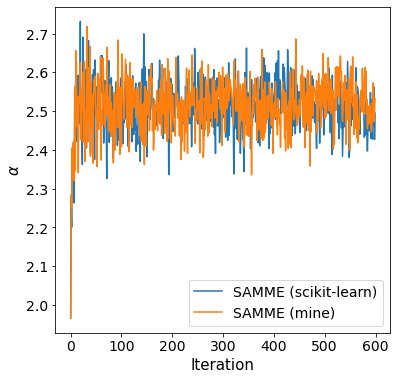

In [6]:
fig = plt.figure(figsize=(6, 6))
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("$\\alpha$", fontsize=15)
plt.plot(sk_model.estimator_weights_, label="SAMME (scikit-learn)")
plt.plot(my_model.alphas, label="SAMME (mine)")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

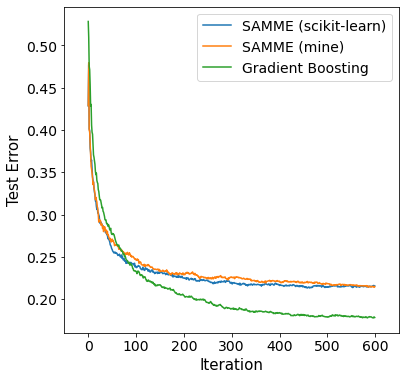

In [7]:
fig = plt.figure(figsize=(6, 6))
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Test Error", fontsize=15)
plt.plot(sk_errors, label="SAMME (scikit-learn)")
plt.plot(my_errors, label="SAMME (mine)")
plt.plot(gb_errors, label="Gradient Boosting")
plt.xlim(-50, 650)
# plt.ylim(0.18, 0.51)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Discussion

+ My implementation of SAMME has almost the same performance as build-in implementation of scikit-learn. They have almost the same weights and the test error path along iterations, which verifys the correctness of my code.
+ To compare SAMME with standard gradient boosting package, we implement scikit-learn ensemble.GradientBoostingClassifier. According to the simulation result, the Gradient Boosting has better performance. In the implementation, although Gradient Boosting and Adaptive Boosting use the same weak learners, i.e., a 10-node decision tree in an additive way, they minimize different loss function. Generally, Gradient Boosting can use any differentiable loss function, while Ada Boosting has to be constrained on Exponential loss. By default, we use "Deviance" loss function in Gradient Boosting, which is more robust to outliers than AdaBoosting. (The Gradient Boosting algorithm in scikit-learn only provide Deviance loss function. The build-in Exponential loss function is only callable for two class classification.)